# Imports

In [1]:
from hw4lib.data import (
    H4Tokenizer,
    LMDataset,
    verify_dataloader
)
from hw4lib.model import (
    CausalMask,
    PadMask,
    PositionalEncoding,
    DecoderOnlyTransformer
)
from hw4lib.trainers import (
    LMTrainer,
)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# Implementations
- `NOTE`: All of these implementations have detailed specification, implementation details, and hints in their respective source files. Make sure to read all of them in their entirety to understand the implementation details!

## MyTorch Implementations
- `TODO`: Copy-paste your implementation of `Linear` from previous assignments into `mytorch/nn/linear.py`.
- `TODO`: Implement the generic `Softmax` activation function in `mytorch/nn/activation.py`.
- `TODO`: Implement the `ScaledDotProductAttention` class in `mytorch/nn/scaled_dot_product_attention.py`.
- `TODO`: Implement the `MultiHeadAttention` class in `mytorch/nn/multi_head_attention.py`.
- `TODO`: Run the cell below to check your implementation.


In [2]:
!python -m tests.test_mytorch


Running tests for category: Softmax
--------------------------------------------------------------------------------

[01/01]    Running:  Softmax Tests
Testing Softmax ...
Test Passed: Softmax Forward
Test Passed: Softmax Backward
[01/01]    PASSED:   Softmax Tests


Running tests for category: ScaledDotProductAttention
--------------------------------------------------------------------------------

[01/01]    Running:  ScaledDotProductAttention Tests
Testing Scaled Dot Product Attention ...
Test Passed: Scaled Dot Product Attention Forward
Test Passed: Scaled Dot Product Attention Backward
[01/01]    PASSED:   ScaledDotProductAttention Tests


Running tests for category: MultiHeadAttention
--------------------------------------------------------------------------------

[01/01]    Running:  MultiHeadAttention Tests
Testing Multi Head Attention ...
Test Passed: Multi Head Attention Forward
Test Passed: Multi Head Attention Backward
[01/01]    PASSED:   MultiHeadAttention Tests


   

## Dataset Implementation
- `TODO`: First, Familiarize yourself with the `tokenize`, `encode`, and `decode` methods of the `H4Tokenizer` class in `hw4lib/data/tokenizer.py`. You will need to make use of these methods in both `HW4P1` and `HW4P2` both in the dataset implementations and during decoding. 
- `TODO`: Implement the `LMDataset` class in `hw4lib/data/lm_dataset.py`. 
- You will have to implement parts of `__init__` and completely implement the `__len__`, `__getitem__` and `collate_fn` methods. 
- `TODO`: Then run the cell below to check your implementation.


In [3]:
!python -m tests.test_dataset_lm

Loading transcripts for text-for-LM/train-text partition...
100%|███████████████████████████████████████| 267/267 [00:00<00:00, 3242.34it/s]

Running tests for category: LMDataset
--------------------------------------------------------------------------------

[01/01]    Running:  Test the LMDataset class
Testing __init__ method ...
Test Passed: Text files are sorted.
Test Passed: Shifted and golden transcripts are aligned.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing __getitem__ method ...
Test Passed: SOS and EOS tokens are correctly placed for samples.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing collate_fn method ...
Test Passed: Transcript batch has correct dimensions (2D tensor).
Test Passed: Transcript lengths are consistent with the batch size.
Test Passed: All sequences are padded to the same length.
Test Passed: Padding values are correct.
Test Passed: Batch transcripts are of c

## Model Implementations
#### Overview:
- `TODO`: Implement the `CausalMask` and `PadMask` functions in `hw4lib/modules/masks.py`.
- `TODO`: Implement the `PositionalEncoding` class in `hw4lib/model/positional_encoding.py`.
- `TODO`: Implement the `SelfAttentionLayer` and `FeedForwardLayer` classes in `hw4lib/model/sublayers.py`.
- `TODO`: Implement the `SelfAttentionDecoderLayer` class in `hw4lib/model/decoder_layers.py`.
- `TODO`: Implement the `DecoderOnlyTransformer` class in `hw4lib/model/transformers.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: Besides the `DecoderOnlyTransformer` (P1 mandatory, P2 optional), you will use all of the above implementations in both `HW4P1` and `HW4P2`!

### Masks 
- `TODO`: Implement the `PadMask` and `CausalMask` functions in `hw4lib/modules/masks.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: You will need to make use of these masks in both `HW4P1` and `HW4P2`.

#### Causal Mask

In [4]:
!python -m tests.test_mask_causal


Running tests for category: CausalMask
--------------------------------------------------------------------------------

[01/01]    Running:  Test the causal mask generation
Testing Causal Mask ...
Test Passed: Causal mask generation is correct.
[01/01]    PASSED:   Test the causal mask generation


                                  Test Summary                                  
Category:    CausalMask                    
Results:     1/1 tests passed (100.0%)


#### Padding Mask

In [5]:
!python -m tests.test_mask_padding


Running tests for category: PaddingMask
--------------------------------------------------------------------------------

[01/01]    Running:  Test the padding mask generation
Testing Padding Mask ...
Test Passed: Padding mask generation is correct.
[01/01]    PASSED:   Test the padding mask generation


                                  Test Summary                                  
Category:    PaddingMask                   
Results:     1/1 tests passed (100.0%)


#### Optional: Visualize your Masks

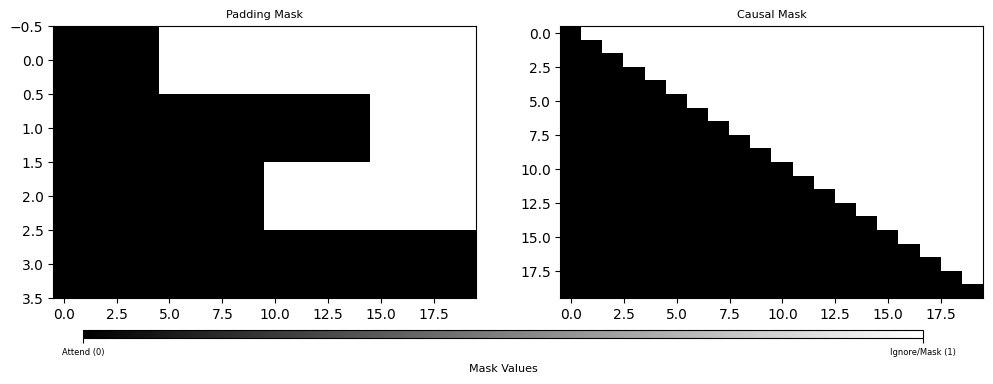

In [6]:
# Dummy data    
_d_model   = 64
_x         = torch.zeros(4, 20, _d_model)
_x_len     = torch.tensor([5, 15, 10, 20])
_x_causal  = CausalMask(_x)
_x_padding = PadMask(_x, _x_len)

# Create figure with two subplots side by side
fig, mask_axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot masks
masks_and_titles = [
    (_x_padding, "Padding Mask"),
    (_x_causal, "Causal Mask")
]

# Plot each mask
images = []
for i, (mask, title) in enumerate(masks_and_titles):
    im = mask_axs[i].imshow(mask, cmap="gray", aspect='auto')
    mask_axs[i].set_title(title, fontsize=8)
    images.append(im)

# Add colorbar at the bottom
fig.subplots_adjust(bottom=0.2)  # Make space for colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(images[0], cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('Mask Values', labelpad=5, fontsize=8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Attend (0)', 'Ignore/Mask (1)'])
cbar.ax.tick_params(labelsize=6)

plt.show()

### Positional Encoding
- `TODO`: Implement the `PositionalEncoding` class in `hw4lib/model/positional_encoding.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: You will need to make use of this positional encoding in both `HW4P1` and `HW4P2`.

In [9]:
!python -m tests.test_positional_encoding


Running tests for category: PositionalEncoding
--------------------------------------------------------------------------------

[01/01]    Running:  Test the positional encoding generation
Testing Positional Encoding Shape ...
Test Passed: Positional Encoding Shape is Correct
Testing Positional Encoding Values ...
Test Passed: Positional Encoding Values are Correct
Testing Positional Encoding Forward ...
Test Passed: Positional Encoding Forward is Correct
[01/01]    PASSED:   Test the positional encoding generation


                                  Test Summary                                  
Category:    PositionalEncoding            
Results:     1/1 tests passed (100.0%)


#### Optional: Visualize your Positional Encoding

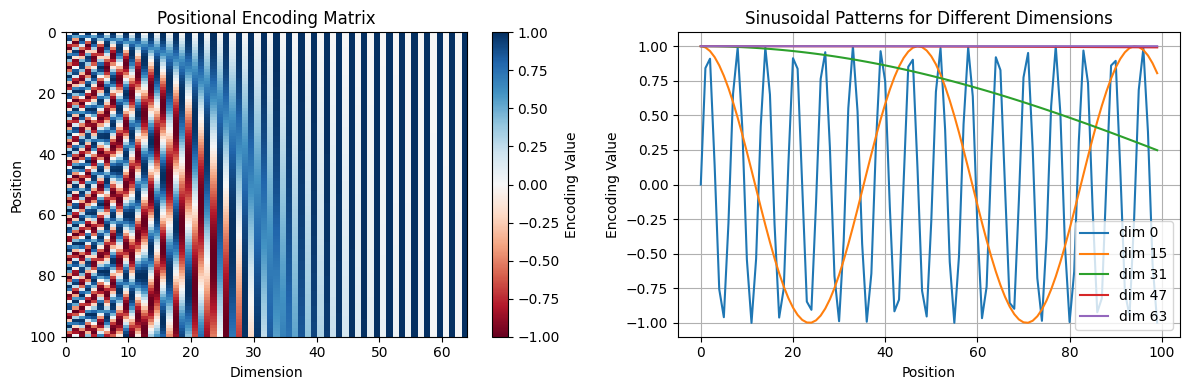

In [10]:
# Create sample positional encoding
d_model = 64
max_len = 100
pos_encoding = PositionalEncoding(d_model=d_model, max_len=max_len)
pe = pos_encoding.pe.squeeze(0).numpy()  # Remove batch dimension and convert to numpy

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Positional encoding matrix
im = ax1.imshow(pe, aspect='auto', cmap='RdBu', 
                extent=[0, d_model, max_len, 0])  # Flip y-axis to show position top-to-bottom
plt.colorbar(im, ax=ax1, label='Encoding Value')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Position')
ax1.set_title('Positional Encoding Matrix')
ax1.grid(False)

# Plot 2: Sinusoidal patterns
dimensions = [0, 15, 31, 47, 63]  # Plot first few dimensions
for dim in dimensions:
    ax2.plot(pe[:, dim], label=f'dim {dim}')
ax2.set_xlabel('Position')
ax2.set_ylabel('Encoding Value')
ax2.set_title('Sinusoidal Patterns for Different Dimensions')
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Transformer Sublayers
- `TODO`: Implement the `SelfAttentionLayer`, and `FeedForwardLayer` classes in `hw4lib/model/sublayers.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: You will need to make use of all of these sublayers in both `HW4P1` and `HW4P2`.

In [11]:
!python -m tests.test_sublayer_selfattention


Running tests for category: SelfAttentionLayer
--------------------------------------------------------------------------------

[01/01]    Running:  Test the self-attention sublayer
Testing initialization ...
Test Passed: All layers exist and are instantiated correctly
Testing forward shapes ...
Test Passed: Forward pass returns the correct shapes
Testing padding mask behaviour ...
Testing padding mask behaviour ...
Test Passed: Padding mask is applied correctly
Testing self-attention mask behaviour ...
Test Passed: Self-attention mask is applied correctly
Testing self-attention residual ...
Test Passed: Residual connection is applied correctly
[01/01]    PASSED:   Test the self-attention sublayer


                                  Test Summary                                  
Category:    SelfAttentionLayer            
Results:     1/1 tests passed (100.0%)


In [12]:
!python -m tests.test_sublayer_feedforward


Running tests for category: FeedForwardLayer
--------------------------------------------------------------------------------

[01/01]    Running:  Test the feedforward sublayer
Testing initialization ...
Test Passed: All layers exist and match reference implementation
Testing forward shapes ...
Test Passed: Forward pass returns correct shapes for various input dimensions
Testing feed-forward network behavior ...
Test Passed: Feed-forward network transforms input appropriately
Testing residual connection ...
Test Passed: Residual connection is working correctly
Testing layer normalization ...
Test Passed: Layer normalization is being applied correctly
Testing forward pass order ...
Test Passed: Forward pass operations are in correct order
[01/01]    PASSED:   Test the feedforward sublayer


                                  Test Summary                                  
Category:    FeedForwardLayer              
Results:     1/1 tests passed (100.0%)


### Transformer Self-Attention Decoder Layer
- `TODO`: Implement the `SelfAttentionDecoderLayer` class in `hw4lib/model/decoder_layers.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: You will need to make use of this sublayer in `HW4P2`.




In [13]:
!python -m tests.test_decoderlayer_selfattention


Running tests for category: SelfAttentionDecoderLayer
--------------------------------------------------------------------------------

[01/01]    Running:  Test the self-attention decoder layer
Testing initialization ...
Test Passed: All sublayers exist and are initialized correctly
Testing forward shapes ...
Test Passed: Forward shapes are as expected
Testing sublayer interaction ...
Test Passed: Sublayers interact correctly
[01/01]    PASSED:   Test the self-attention decoder layer


                                  Test Summary                                  
Category:    SelfAttentionDecoderLayer     
Results:     1/1 tests passed (100.0%)


### Decoder-Only Transformer

- `TODO`: Implement the  `DecoderOnlyTransformer` class in `hw4lib/model/transformers.py`.
- `TODO`: Then run the cell below to check your implementation.
- `NOTE`: You will need to make use of in `HW4P1` and optionally `HW4P2`.

In [14]:
!python -m tests.test_transformer_decoder_only


Running tests for category: DecoderOnlyTransformer
--------------------------------------------------------------------------------

[01/01]    Running:  Test the decoder only transformer
Testing initialization...
Test Passed: All components initialized correctly
Testing forward pass...
Test Passed: Forward pass works correctly
Testing forward propagation order...
Test Passed: Forward propagation order is correct
[01/01]    PASSED:   Test the decoder only transformer


                                  Test Summary                                  
Category:    DecoderOnlyTransformer        
Results:     1/1 tests passed (100.0%)


## Decoding Implementations 
- `TODO`: Implement the `generate_greedy` method of the `SequenceGenerator` class in `hw4lib/decoding/sequence_generator.py`.
- `TODO`: Then run the cell below to check your implementation.

In [15]:
!python -m tests.test_decoding --mode greedy


Running tests for category: Decoding
--------------------------------------------------------------------------------

[01/01]    Running:  Test greedy decoding
Testing Single Batch Greedy Search ...
Generated: HELLO WORLD  | Expected: HELLO WORLD 
Testing Multi Batch Greedy Search ...
Batch 0  : Generated: HELLO WORLD  | Expected: HELLO WORLD 
Batch 1  : Generated: GOOD BYE     | Expected: GOOD BYE    
[01/01]    PASSED:   Test greedy decoding


                                  Test Summary                                  
Category:    Decoding                      
Results:     1/1 tests passed (100.0%)


# Experiments

## Config

- `TA-TODO`: Set your config based on what you have been assigned on the ablation sheet. 

In [ ]:
%%writefile config.yaml

Name                      : "Puru"

###### Tokenization ------------------------------------------------------------
tokenization:
  token_type                : "1k"       # [char, 1k, 5k, 10k]
  token_map :
      'char': 'hw4lib/data/tokenizer_jsons/tokenizer_char.json'
      '1k'  : 'hw4lib/data/tokenizer_jsons/tokenizer_1000.json'
      '5k'  : 'hw4lib/data/tokenizer_jsons/tokenizer_5000.json'
      '10k' : 'hw4lib/data/tokenizer_jsons/tokenizer_10000.json'

###### Dataset -----------------------------------------------------------------
data:
  root                 : "hw4_data_subset"            # TODO: Set the root path of your data
  train_partition      : "text-for-LM/train-text"  # unpaired text for LM pre-training
  val_partition        : "text-for-LM/val-text"    # unpaired text for LM pre-training
  test_partition       : "text-for-LM/test-text"   # unpaired text for LM pre-trainin
  subset               : 1.0          # Load a subset of the data (for debugging, testing, etc
  batch_size           : 8            # Set to 0 for CPU  
  NUM_WORKERS          : 2            # Set to 0 for CPU

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 256
  d_ff                      : 512
  num_layers                : 2
  num_heads                 : 2
  dropout                   : 0.1
  layer_drop_rate           : 0.1
  weight_tying              : False

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False
  epochs                      : 5
  gradient_accumulation_steps : 1

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' CrossEntropy
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adam" # Options: sgd, adam, adamw
  lr: 0.0001  # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: ["self_attn"]  # Will match all parameters containing "encoder"
      lr: 0.0001  # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8
    
    - name: ffn
      patterns: ["ffn"]
      lr: 0.0001  # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8
  
  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine_warm"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 35  # Maximum number of iterations
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: False
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0



In [15]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Tokenizer

In [ ]:
Tokenizer = H4Tokenizer(
    token_map  = config['tokenization']['token_map'], 
    token_type = config['tokenization']['token_type']
)

## Datasets

In [ ]:
train_dataset  = LMDataset(
    partition  = config['data']['train_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

val_dataset    = LMDataset(
    partition  = config['data']['val_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

test_dataset   = LMDataset(
    partition  = config['data']['test_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)   

gc.collect()

## Dataloaders

In [18]:
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = True,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn   
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn   
)

test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn   
)

### Dataloader Verification

In [ ]:
verify_dataloader(train_loader)

In [ ]:
verify_dataloader(val_loader)

In [ ]:
verify_dataloader(test_loader)

## Calculate Max Transcript Length 




Calculating the maximum transcript length across your dataset is a crucial step when working with certain transformer models. 
-  We'll use sinusoidal positional encodings that must be precomputed up to a fixed maximum length.
- This maximum length is a hyperparameter that determines:
  - How long of a sequence your model can process
  - The size of your positional encoding matrix
  - Memory requirements during training and inference
- `Requirements`: For this assignment, ensure your positional encodings can accommodate at least the longest sequence in your dataset to prevent truncation. However, you can set this value higher if you anticipate using your languagemodel to work with longer sequences in future tasks (hint: this might be useful for P2! 😉).

In [ ]:
max_transcript_length = max(train_dataset.text_max_len, val_dataset.text_max_len, test_dataset.text_max_len)
print("="*50)
print(f"{'Global Max Transcript Length':<30} : {max_transcript_length}")
print("="*50)

## Model

In [ ]:
model = DecoderOnlyTransformer(
    num_layers      = config['model']['num_layers'],
    d_model         = config['model']['d_model'],
    num_heads       = config['model']['num_heads'],
    d_ff            = config['model']['d_ff'],
    dropout         = config['model']['dropout'],    
    max_len         = max_transcript_length,
    num_classes     = Tokenizer.vocab_size,
    weight_tying    = config['model']['weight_tying'],
    layer_drop_rate = config['model']['layer_drop_rate']
)

# Get some inputs from the text loader
for batch in train_loader:
    shifted_transcripts, golden_transcripts, transcript_lengths = batch
    break 

model_stats = summary(model, input_data=[shifted_transcripts, transcript_lengths])
print(model_stats)

## Trainer
You will have to do some minor in-filling for the `LMTrainer` class in `hw4lib/trainers/lm_trainer.py` before you can use it.
- `TODO`: Fill in the `TODO`s in the `__init__`.
- `TODO`: Fill in the `TODO`s in the `_train_epoch`.
- `TODO`: Fill in the `TODO`s in the `_evaluate_epoch`.
- `TODO`: Fill in the `TODO`s in the `train` method.
- `TODO`: Fill in the `TODO`s in the `evaluate` method.
- `TODO`: Fill in the `TODO`s in the `generate` method.


In [ ]:
trainer = LMTrainer(
    model=model,
    tokenizer=Tokenizer,
    config=config,
    run_name="Puru",
    config_file="config.yaml"
)

# Train

In [ ]:
trainer.train(train_loader, val_loader)

# Evaluate


In [ ]:
test_metrics, test_generation_results = trainer.evaluate(test_loader)

# Submission
To submit your assignment, you will need to create a `handin.tar` with the following directory structure:

```
handin/
├── mytorch/                    # Your implemented modules
│   ├── __init__.py
│   ├── softmax.py              # Softmax implementation
│   ├── attention.py            # Attention implementations
│   └── ...
├── test_metrics.json     # Results from evaluation
├── test_generated_results.json    # Sample text generations
└── model_arch.txt              # Model architecture summary
```

- `TODO`: Simply run the cell below once you are satisfied with your current state and this will create the `handin.tar` file.





In [ ]:
# Create temporary handin directory
if os.path.exists('handin'):
    shutil.rmtree('handin')
os.makedirs('handin')

# Copy mytorch directory
shutil.copytree('mytorch', 'handin/mytorch')

# Save final results
with open('handin/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)

with open('handin/test_generated_results.json', 'w') as f:
    json.dump(test_generation_results['greedy'], f, indent=4)

# Save model architecture
with open('handin/model_arch.txt', 'w') as f:
    f.write(str(model_stats))

# Create tar file with all exclusions handled by filter
with tarfile.open('handin.tar', 'w') as tar:
    def filter_files(tarinfo):
        # Skip unwanted files
        if any(pattern in tarinfo.name for pattern in [
            '.DS_Store',
            '__pycache__',
            '.pyc'
        ]):
            return None
        return tarinfo
    
    tar.add('handin', arcname='handin', filter=filter_files)

# Cleanup
shutil.rmtree('handin')

print("Created handin.tar successfully!")

# 